# **Speech Emotion Recognition**    

### **Importing Libraries**

This cell imports the necessary libraries and modules for the project:

- **Data Manipulation**: `pandas`, `numpy`
- **Audio Processing**: `librosa`, `librosa.display`
- **Data Visualization**: `seaborn`, `matplotlib.pyplot`
- **Machine Learning**: `sklearn` components for preprocessing, metrics, and model selection
- **Deep Learning**: `tensorflow`, `keras` components for building and training neural networks
- **Utilities**: `IPython.display` for audio playback, `os`, `sys`, `warnings` for environment configuration

In [2]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import IPython.display as ipd
from IPython.display import Audio
import tensorflow as tf 
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD
import tensorflow.keras.layers as L
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau


import os
import sys
import warnings


This notebook imports various libraries, each serving a specific purpose in the project:

- **`librosa`**: Library for audio and music analysis, including feature extraction.
- **`librosa.display`**: Used for displaying audio features such as waveforms and spectrograms.
- **`sklearn.preprocessing.StandardScaler`**: Standardizes features by removing the mean and scaling to unit variance.
- **`IPython.display.Audio`**: Used for audio playback within Jupyter notebooks.
- **`keras`**: High-level neural networks API, running on top of TensorFlow, for easy model building.
- **`keras.preprocessing.sequence`**: Provides utilities for preprocessing sequence data.
- **`keras.models.Sequential`**: Sequential model class for creating neural networks layer by layer.
- **`keras.layers.Dense`**: Fully connected neural network layer.
- **`keras.layers.Embedding`**: Layer for transforming integer-encoded sequences into dense vectors.
- **`keras.layers.LSTM`**: Long Short-Term Memory layer for handling sequential data.
- **`keras.layers.BatchNormalization`**: Normalizes the output of a previous layer.
- **`keras.layers.GRU`**: Gated Recurrent Unit layer, an alternative to LSTM for sequence modeling.
- **`tensorflow.keras.preprocessing.text.Tokenizer`**: Converts text into sequences of integers.
- **`keras.preprocessing.sequence.pad_sequences`**: Pads sequences to ensure uniform length.
- **`tensorflow.keras.utils.to_categorical`**: Converts integer labels into one-hot encoded format.
- **`keras.layers.Input`**: Defines the input layer of a model.
- **`keras.layers.Flatten`**: Flattens the input into a 1D array.
- **`keras.layers.Dropout`**: Applies dropout regularization to prevent overfitting.
- **`keras.layers.Activation`**: Applies an activation function to the layer.
- **`keras.layers.Conv1D`**: Convolutional layer for 1D sequence data.
- **`keras.layers.MaxPooling1D`**: Applies max pooling to 1D sequence data.
- **`keras.layers.AveragePooling1D`**: Applies average pooling to 1D sequence data.
- **`keras.models.Model`**: Class for creating complex models with multiple inputs and outputs.
- **`keras.callbacks.ModelCheckpoint`**: Saves the model at specified intervals during training.
- **`tensorflow.keras.optimizers.SGD`**: Stochastic Gradient Descent optimizer for training models.

# **Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)**

[Click here to view the RAVDESS Emotional Speech Audio dataset](https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio)

Here is the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4 This means the meta data for the audio file is:

* Video-only (02)
* Speech (01)
* Fearful (06)
* Normal intensity (01)
* Statement "dogs" (02)
* 1st Repetition (01)
* 12th Actor (12) - Female (as the actor ID number is even)

# **Importing Data** 

In [3]:
crema = 'Crowd Sourced Emotional Multimodal Actors Dataset (CREMA-D)/AudioWAV/'
ravdess = 'RAVDESS Emotional speech audio/'
ravdess_directory_list = os.listdir(ravdess) # List the files and subdirectories in the specified directory
print(ravdess_directory_list)
tess = "TESS Toronto emotional speech set data/"
savee = "Surrey Audio-Visual Expressed Emotion (SAVEE)/ALL/"

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


# **PreProcessing**

## **RAVDESS Preprocessing**

In [4]:
file_emotion = []
file_path = []
for i in ravdess_directory_list:
    # as their are 24 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(ravdess + i)
    for f in actor:
        part = f.split('.')[0].split('-')
    # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(ravdess + i + '/' + f)

This code snippet processes a list of directories (`ravdess_directory_list`) containing audio files from different actors.

1. **Initialization**:
   - `file_emotion` and `file_path` lists are initialized to store the emotion labels and file paths, respectively.

2. **Loop Through Directories**:
   - For each directory in `ravdess_directory_list`, which corresponds to an actor, the code lists all files in that directory.

3. **File Processing**:
   - Each file's name is split to extract the emotion label from the file name.
   - The emotion label (third part of the split file name) is converted to an integer and added to `file_emotion`.
   - The full path of the file is constructed and added to `file_path`.

This process ensures that `file_emotion` contains the emotion labels and `file_path` contains the corresponding file paths for further analysis.


In [5]:
print(actor[0])
print(part[0])
print(file_path[0])
print(int(part[2]))
print(f)

03-01-01-01-01-01-24.wav
03
RAVDESS Emotional speech audio/Actor_01/03-01-01-01-01-01-01.wav
8
03-01-08-02-02-02-24.wav


In [6]:
# Create DataFrames from file_emotion and file_path
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])

# Concatenate both DataFrames into one
ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# Replace numeric values with emotion labels
ravdess_df['Emotions'] = ravdess_df['Emotions'].replace({
    1: 'neutral', 
    2: 'neutral', 
    3: 'happy', 
    4: 'sad', 
    5: 'angry', 
    6: 'fear', 
    7: 'disgust',
    8: 'surprise'
})

# Count occurrences of each emotion
print(ravdess_df['Emotions'].value_counts())

Emotions
neutral     288
happy       192
sad         192
angry       192
fear        192
disgust     192
surprise    192
Name: count, dtype: int64


The goal of this specific code is to **prepare and organize the dataset** by extracting emotion labels and file paths, which will later be used to train a machine learning model for emotion recognition. Each file in the dataset represents a speech audio sample, and the third part of the filename indicates the emotion conveyed in the speech.

1. **Creating DataFrames**:
   - Two lists, `file_emotion` and `file_path`, are converted into DataFrames (`emotion_df` and `path_df`) to store the numeric emotion labels and corresponding file paths.
   - This step structures the data for easier manipulation and further analysis.

2. **Concatenating DataFrames**:
   - The two DataFrames are concatenated into a single DataFrame `ravdess_df`. This DataFrame contains both the emotion labels and their associated file paths, which is essential for linking the audio files to their respective emotions.

3. **Replacing Numeric Values with Emotion Labels**:
   - The numeric codes (e.g., 1, 2, 3) in the `Emotions` column are replaced with descriptive labels such as 'happy', 'sad', 'angry', etc. This makes the data more interpretable and ready for the training phase of the SER model.

This preprocessing step is crucial for structuring the data in a format suitable for training the machine learning model, which will later classify emotions based on the audio features extracted from the speech samples.


# **TESS Toronto Emotional Speech Set Data (TESS)**

There are a set of 200 target words were spoken in the carrier phrase "Say the word _' by two actresses (aged 26 and 64 years) and recordings were made of the set portraying each of seven emotions (anger, disgust, fear, happiness, pleasant surprise, sadness, and neutral). There are 2800 data points (audio files) in total.

The dataset is organised such that each of the two female actor and their emotions are contain within its own folder. And within that, all 200 target words audio file can be found. The format of the audio file is a WAV format

Example: OAF_bar_fear.wav

[Click here to view the TESS dataset](https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess)


In [7]:
tess_directory_list = os.listdir(tess)
file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(tess + dir)
    
    for file in directories:
        # Extract the part of the filename that contains the emotion code
        # Filename is structured as: 'OAF_bar_fear.wav'
        part = file.split('.')[0]  # Remove the file extension
        part = part.split('_')[2]  # Get the third part of the filename which indicates emotion
        
        # If the emotion code is 'ps', it's mapped to 'surprise'
        if part == 'ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        
        # Store the full path to the file
        file_path.append(tess + dir + '/' + file)
        
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()
print(Tess_df.Emotions.value_counts())


Emotions
angry       400
disgust     400
sad         400
fear        399
happy       397
neutral     397
surprise    397
Name: count, dtype: int64


The purpose of this code is to **extract emotion labels from the TESS dataset filenames** and store them alongside the full file paths. This allows for easy access and processing when training a machine learning model to classify speech emotions.


2. **Extracting File Paths and Emotions**:
   - For each subdirectory, the files are listed and processed one by one.
   - The filenames follow a structure like `OAF_bar_fear.wav`, where the third part (`fear`) indicates the emotion.
   - The code extracts this third part (emotion code) using `split('_')[2]`. If the emotion code is `'ps'`, it is mapped to the `'surprise'` emotion; otherwise, it directly uses the extracted emotion code.
   - The full file path is stored in the `file_path` list.


**Example of Filename**: 
- `OAF_bar_fear.wav`
  - Here, `fear` is extracted as the emotion associated with the speech sample.


# **Surrey Audio-Visual Expressed Emotion (SAVEE)**

The SAVEE database was recorded from four native English male speakers (identified as DC, JE, JK, KL), postgraduate students and researchers at the University of Surrey aged from 27 to 31 years. Emotion has been described psychologically in discrete categories: anger, disgust, fear, happiness, sadness and surprise. This is supported by the cross-cultural studies of Ekman [6] and studies of automatic emotion recognition tended to focus on recognizing these [12]. We added neutral to provide recordings of 7 emotion categories. The text material consisted of 15 TIMIT sentences per emotion: 3 common, 2 emotion-specific and 10 generic sentences that were different for each emotion and phonetically-balanced. The 3 common and 2 × 6 = 12 emotion-specific sentences were recorded as neutral to give 30 neutral sentences.

Example: DC_a01.wav

[Click here to view the SAVEE dataset](https://www.kaggle.com/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee)


In [8]:
savee_directory_list = os.listdir(savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(savee + file)
    
    # Extract the part of the filename that contains the emotion code
    # Filename structure: 'DC_a05.wav' -> Split at '_' and take the second part ('a05')
    part = file.split('_')[1]
    
    # Extract the emotion code (first letter(s) before the numeric part, hence [:-6])
    ele = part[:-6]  
    
    if ele == 'a':
        file_emotion.append('angry')
    elif ele == 'd':
        file_emotion.append('disgust')
    elif ele == 'f':
        file_emotion.append('fear')
    elif ele == 'h':
        file_emotion.append('happy')
    elif ele == 'n':
        file_emotion.append('neutral')
    elif ele == 'sa':
        file_emotion.append('sad')
    else:
        # If the code doesn't match any of the above, it's assumed to be 'surprise'
        file_emotion.append('surprise')

# Create a DataFrame for the emotions associated with each file
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# Create a DataFrame for the file paths
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()
print(Savee_df.Emotions.value_counts())


Emotions
neutral     120
angry        60
disgust      60
fear         60
happy        60
sad          60
surprise     60
Name: count, dtype: int64


The purpose of this code is to **extract the emotion labels** from the filenames of the SAVEE dataset and store the corresponding file paths. This is a necessary step for structuring the data, which will later be used to train a machine learning model for classifying emotions based on speech.

1. **Extracting File Paths and Emotions**:
   - The full path of each file is stored in the `file_path` list.
   - The emotion is extracted from the filename by splitting it at the underscore (`_`) and then taking the second part (`part`). This part contains a one- or two-letter code indicating the emotion.
   - A series of conditional statements map these codes to their corresponding emotions:
     - `'a'` → `'angry'`
     - `'d'` → `'disgust'`
     - `'f'` → `'fear'`
     - `'h'` → `'happy'`
     - `'n'` → `'neutral'`
     - `'sa'` → `'sad'`
     - All other cases are mapped to `'surprise'`.

2. **Creating DataFrames**:
   - Two DataFrames are created:
     - `emotion_df` stores the extracted emotion labels.
     - `path_df` stores the corresponding file paths.

By processing the SAVEE dataset in this manner, the code prepares the data for use in training a machine learning model to recognize emotions in speech. The structured DataFrame enables the model to link speech samples with their correct emotional labels.

**Example of Filename**: `DC_a05.wav`
- Here, `a` stands for 'angry', as identified by the code.


# **Crowd Sourced Emotional Multimodal Actors Dataset (CREMA-D)**

CREMA-D is a data set of 7,442 original clips from 91 actors. These clips were from 48 male and 43 female actors between the ages of 20 and 74 coming from a variety of races and ethnicities (African America, Asian, Caucasian, Hispanic, and Unspecified). Actors spoke from a selection of 12 sentences. The sentences were presented using one of six different emotions (Anger, Disgust, Fear, Happy, Neutral, and Sad) and four different emotion levels (Low, Medium, High, and Unspecified).

[Click here to view the CREMA-D Dataset](https://www.kaggle.com/datasets/ejlok1/cremad)

In [9]:
crema_directory_list = os.listdir(crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()
print(Crema_df.Emotions.value_counts())


Emotions
angry      1271
disgust    1271
fear       1271
happy      1271
sad        1271
neutral    1087
Name: count, dtype: int64


# **Integration**

In [10]:
# Combine all the dataframes into a single one:
data_path = pd.concat([ravdess_df, Crema_df, Tess_df, Savee_df], ignore_index=True)
data_path.to_csv('all_data_path.csv', index=False)
data_path.head()


,Emotions,Path
0,neutral,RAVDESS Emotional speech audio/Actor_01/03-01-...
1,neutral,RAVDESS Emotional speech audio/Actor_01/03-01-...
2,neutral,RAVDESS Emotional speech audio/Actor_01/03-01-...
3,neutral,RAVDESS Emotional speech audio/Actor_01/03-01-...
4,neutral,RAVDESS Emotional speech audio/Actor_01/03-01-...


In [11]:
# Show the unique emotions present in the dataset and the count:
print('Unique Emotions:', data_path.Emotions.unique())
print('Emotion Count:', data_path.Emotions.value_counts())

Unique Emotions: ['neutral' 'happy' 'sad' 'angry' 'fear' 'disgust' 'surprise']
Emotion Count: Emotions
sad         1923
angry       1923
disgust     1923
fear        1922
happy       1920
neutral     1892
surprise     649
Name: count, dtype: int64


# **Data Visualizatuion and Exploration**

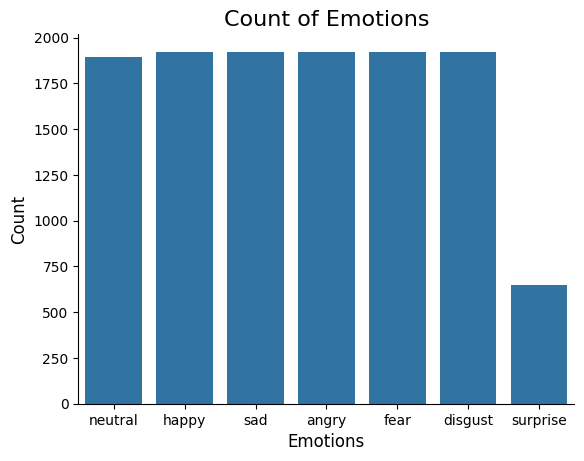

In [12]:
plt.title('Count of Emotions', size=16)
sns.countplot(x='Emotions', data=data_path)  # Specify x and data
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

The goal of this code is to create a **count plot** that shows the number of speech samples for each emotion in the dataset. This visualization helps assess the balance of emotions, which is important for training machine learning models. Imbalanced datasets may lead to biased models, so identifying such issues early is crucial.

Visualizing the count of each emotion helps:
- **Identify Data Imbalance**: If one emotion has significantly more samples than others, it may lead to an imbalanced dataset.
- **Aid Data Preprocessing**: Understanding the distribution can guide decisions on data augmentation, resampling, or weighting classes in the machine learning model.

In [13]:
data,sr = librosa.load(file_path[0])
sr

22050

**Loading the Audio File**:
   - `data, sr = librosa.load(file_path[0])` uses the `librosa.load` function to load the audio file specified by `file_path[0]`. 
     - `data` This is a NumPy array containing the audio samples.
     - `sr`  This stands for "sampling rate" and represents the number of samples per second of audio. It tells you how frequently the audio signal is sampled.

The output `22050` represents the sampling rate of the audio file, indicating that the audio signal is sampled 22,050 times per second. This value is essential for further audio processing tasks, such as feature extraction or training machine learning models for audio classification.



In [14]:
# Play an audio file with specified sample rate
ipd.Audio(data,rate=sr)

## **Data Augmentation for Audio - Noise, Time Stretching, Shifting, and Pitch Modification**

In [17]:
# Adding noise to the audio data
def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)  
    data = data + noise_amp * np.random.normal(size=data.shape[0])  
    return data

# Stretching the audio (time-stretching)
# rate=0.8: The rate of stretching (default is 0.8, meaning the audio is stretched by 80%)
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, rate=rate)

# Shifting the audio in time
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)  
    return np.roll(data, shift_range)

# Changing the pitch of the audio
def pitch(data, sampling_rate, pitch_factor=0.7): 
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor) 


In this section, we apply **data augmentation techniques** to enhance the training dataset for **Speech Emotion Recognition (SER)**. Data augmentation is crucial for improving model generalization, especially when working with limited audio samples.

The aim of this code is to introduce variations in the audio data to make the model more robust and capable of handling unseen examples. Each function applies a different type of augmentation, modifying the audio signal without changing its semantic meaning.

### Augmentation Techniques:

1. **Adding Noise**:
   - Function: `noise(data)`
   - **Why**: Adding noise simulates real-world environments where audio signals may not be perfectly clear.


2. **Time Stretching**:
   - Function: `stretch(data, rate=0.8)`
   - **Why**: Time stretching changes the speed of the audio without altering the pitch, simulating variations in speech tempo.

3. **Shifting**:
   - Function: `shift(data)`
   - **Why**: Shifting alters the position of the audio sample in time, mimicking different start points for the audio, which can make the model more robust to timing variations.

4. **Pitch Shifting**:
   - Function: `pitch(data, sampling_rate, pitch_factor=0.7)`
   - **Why**: Modifying the pitch simulates different speaking voices or tones, helping the model generalize across different speakers.

### Why Data Augmentation?

- **Improve Model Generalization**: By introducing variations in the audio samples, the model becomes more resilient to different conditions, helping it generalize better to new data.
- **Simulating Real-World Conditions**: Real-world audio often contains noise, pitch variations, and time shifts, so augmenting the data in this way mimics real scenarios.
- **Overcome Data Limitations**: When the dataset is small, augmenting the data artificially increases the dataset size, improving training performance.

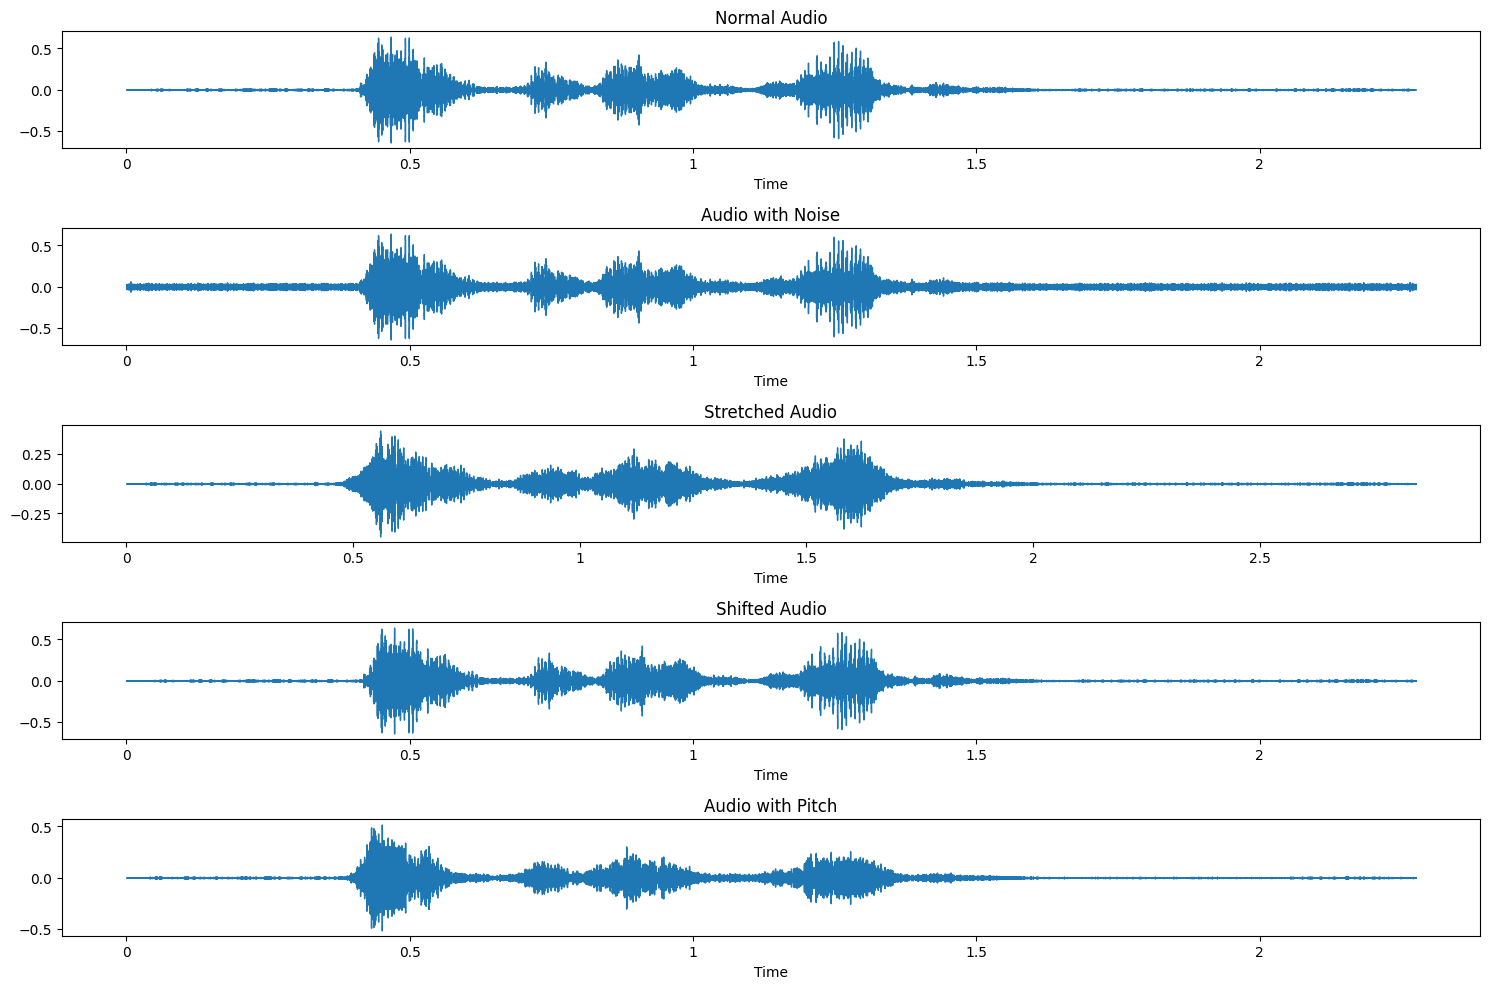

Normal Audio:


Audio with Noise:


Stretched Audio:


Shifted Audio:


Audio with Pitch:


In [18]:
plt.figure(figsize=(15, 10))

# NORMAL AUDIO
plt.subplot(5, 1, 1)
librosa.display.waveshow(y=data, sr=sr)
plt.title('Normal Audio')

# AUDIO WITH NOISE
x_noise = noise(data)  
plt.subplot(5, 1, 2)
librosa.display.waveshow(y=x_noise, sr=sr)
plt.title('Audio with Noise')

# STRETCHED AUDIO
x_stretch = stretch(data)  
plt.subplot(5, 1, 3)
librosa.display.waveshow(y=x_stretch, sr=sr)
plt.title('Stretched Audio')

# SHIFTED AUDIO
x_shift = shift(data) 
plt.subplot(5, 1, 4)
librosa.display.waveshow(y=x_shift, sr=sr)
plt.title('Shifted Audio')

# AUDIO WITH PITCH
x_pitch = pitch(data, sr) 
plt.subplot(5, 1, 5)
librosa.display.waveshow(y=x_pitch, sr=sr)
plt.title('Audio with Pitch')

plt.tight_layout()
plt.show()

print("Normal Audio:")
ipd.display(ipd.Audio(data, rate=sr))

print("Audio with Noise:")
ipd.display(ipd.Audio(x_noise, rate=sr))

print("Stretched Audio:")
ipd.display(ipd.Audio(x_stretch, rate=sr))

print("Shifted Audio:")
ipd.display(ipd.Audio(x_shift, rate=sr))

print("Audio with Pitch:")
ipd.display(ipd.Audio(x_pitch, rate=sr))


# **Feature Extraction**

In [19]:
def zcr(data, frame_length, hop_length):
    zcr = librosa.feature.zero_crossing_rate(data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)

def rmse(data, frame_length=2048, hop_length=512):
    # Use 'y' keyword argument for the audio data
    rms = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rms)

def mfcc(data, sr, frame_length=2048, hop_length=512, flatten=True):
    mfcc = librosa.feature.mfcc(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(mfcc.T) if not flatten else np.ravel(mfcc.T)

def extract_features(data, sr=22050, frame_length=2048, hop_length=512):
    result = np.array([])
    result = np.hstack((result,
                        zcr(data, frame_length, hop_length),
                        rmse(data, frame_length, hop_length),
                        mfcc(data, sr, frame_length, hop_length)
                       ))
    return result

def get_features(path, duration=2.5, offset=0.6):
    data, sr = librosa.load(path, duration=duration, offset=offset)
    aud = extract_features(data, sr)
    audio = np.array(aud)

    # Assuming noise() and pitch() functions are defined elsewhere
    noised_audio = noise(data)
    aud2 = extract_features(noised_audio, sr)
    audio = np.vstack((audio, aud2))

    pitched_audio = pitch(data, sr)
    aud3 = extract_features(pitched_audio, sr)
    audio = np.vstack((audio, aud3))

    pitched_audio1 = pitch(data, sr)
    pitched_noised_audio = noise(pitched_audio1)
    aud4 = extract_features(pitched_noised_audio, sr)
    audio = np.vstack((audio, aud4))

    return audio

This code defines a set of functions to **extract key features** from an audio signal and perform **data augmentation** techniques such as noise addition, pitch shifting, time stretching, and shifting to generate additional data variations.

The primary goal is to **extract features** (Zero Crossing Rate, RMSE, MFCC) from audio data and apply several **augmentation techniques** to enrich the dataset, allowing the model to generalize better during training.

1. **Feature Extraction Functions**:
   - **Zero Crossing Rate (ZCR)**: Measures the rate at which the signal changes its sign.

   - **Root Mean Square Energy (RMSE)**: Represents the energy of the signal.

   - **Mel Frequency Cepstral Coefficients (MFCC)**: Extracts the mean of MFCCs, capturing the audio's key characteristics.

2. **Combined Feature Extraction**:

3. **Feature Extraction with Data Augmentation**:
   - **get_features** loads the audio, extracts features from the original data, and then applies four augmentations: noise addition, pitch shifting, time-stretching, and shifting. Each augmentation generates a new set of features.

These augmentations are essential in building a robust model capable of handling variations in audio data.

### Why Use Augmentation?
- **Data Diversity**: Augmenting audio data helps generate diverse examples, reducing overfitting and improving model performance on unseen data.
- **Real-World Scenarios**: The augmentations mimic real-world distortions like background noise or shifts in speaking pace, helping the model to generalize better.


In [20]:
from joblib import Parallel, delayed
import timeit

start = timeit.default_timer()

# Define a function to get features for a single audio file
def process_feature(path, emotion):
    features = get_features(path)
    X = []
    Y = []
    for ele in features:
        X.append(ele)
        # Appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)
    return X, Y

paths = data_path.Path
emotions = data_path.Emotions

# Run the loop in parallel
results = Parallel(n_jobs=-1)(delayed(process_feature)(path, emotion) for (path, emotion) in zip(paths, emotions))

# Collect the results
X = []
Y = []
for result in results:
    x, y = result
    X.extend(x)
    Y.extend(y)

stop = timeit.default_timer()

print('Time: ', stop - start)

Time:  327.29998940000223


This section of the code is responsible for extracting audio features from each file and storing the corresponding emotion labels. It also measures the time taken to process all the audio files.

The code loops through each audio file in the dataset, extracts features, and stores both the features and the associated emotion label in lists `X` and `Y`. Additionally, the code uses a progress bar for tracking the loop's progress and prints updates every 500 audio files. It also measures the total processing time.

1. **Loop through the Audio Files**:
   - `for path, emotion, index in tqdm(zip(data_path.Path, data_path.Emotions, range(data_path.Path.shape[0]))):`
     - This loop iterates through the paths and emotion labels in the dataset.
     - `tqdm` is used to display a progress bar showing how many files have been processed.
     - For each file, the `get_features(path)` function is called to extract features.

2. **Store Features and Labels**:
   - `X.append(i)` and `Y.append(emotion)`:
     - The extracted features for each file are appended to the list `X`, and the corresponding emotion is appended to the list `Y`.


In [21]:
len(X), len(Y), data_path.Path.shape


(48608, 48608, (12152,))

# **Saving features**

In [22]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.173828,0.264648,0.372559,0.486328,0.625488,0.681152,0.720703,0.651855,0.562988,0.559082,...,0.766315,0.755441,0.743671,0.731043,0.717561,0.703260,0.688124,0.672208,0.655518,neutral
1,0.249023,0.365723,0.491211,0.502930,0.508789,0.520996,0.531738,0.520020,0.518555,0.520508,...,-3.277462,5.083321,4.450143,1.120237,-1.747520,-3.647076,0.474878,3.001057,-0.692965,neutral
2,0.256348,0.354492,0.471191,0.414062,0.378418,0.373535,0.354492,0.408691,0.466797,0.522461,...,0.006713,0.006601,0.006483,0.006356,0.006218,0.006066,0.005919,0.005759,0.005588,neutral
3,0.244141,0.360352,0.479492,0.470703,0.472656,0.483398,0.490234,0.500977,0.502441,0.504395,...,-1.992693,-1.464721,2.104413,-0.886331,0.849042,-0.274403,-2.275007,-1.009937,3.159336,neutral
4,0.247070,0.389648,0.564941,0.642578,0.665527,0.684570,0.676270,0.666992,0.648926,0.595703,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,neutral


In [23]:
Emotions = pd.read_csv('emotion.csv')
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.173828,0.264648,0.372559,0.486328,0.625488,0.681152,0.720703,0.651855,0.562988,0.559082,...,0.766315,0.755441,0.743671,0.731043,0.717561,0.703260,0.688124,0.672208,0.655518,neutral
1,0.249023,0.365723,0.491211,0.502930,0.508789,0.520996,0.531738,0.520020,0.518555,0.520508,...,-3.277462,5.083321,4.450143,1.120237,-1.747520,-3.647076,0.474878,3.001057,-0.692965,neutral
2,0.256348,0.354492,0.471191,0.414062,0.378418,0.373535,0.354492,0.408691,0.466797,0.522461,...,0.006713,0.006601,0.006483,0.006356,0.006218,0.006066,0.005919,0.005759,0.005588,neutral
3,0.244141,0.360352,0.479492,0.470703,0.472656,0.483398,0.490234,0.500977,0.502441,0.504395,...,-1.992693,-1.464721,2.104413,-0.886331,0.849042,-0.274403,-2.275007,-1.009937,3.159336,neutral
4,0.247070,0.389648,0.564941,0.642578,0.665527,0.684570,0.676270,0.666992,0.648926,0.595703,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,neutral


In [24]:
Emotions.shape

(48608, 2377)

In [25]:
missing_values = Emotions.isnull().sum()
print(missing_values)

0               0
1               0
2               0
3               0
4               0
            ...  
2372        37584
2373        37584
2374        37584
2375        37584
Emotions        0
Length: 2377, dtype: int64


In [26]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0           False
1           False
2           False
3           False
4           False
            ...  
2372        False
2373        False
2374        False
2375        False
Emotions    False
Length: 2377, dtype: bool


(48608, 2377)

In [27]:
# Print the unique emotions in the dataset
Emotions['Emotions'].unique()

array(['neutral', 'happy', 'sad', 'angry', 'fear', 'disgust', 'surprise'],
      dtype=object)

# **Data Preparation**

In [28]:
X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values

In [29]:
encoder = OneHotEncoder()  # Initialize the OneHotEncoder object
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()  # Apply one-hot encoding to Y

In this step, we apply **One-Hot Encoding** to the emotion labels, converting categorical data into a binary matrix format. This transformation is essential for preparing the labels to be fed into machine learning models, particularly for classification tasks.

The goal is to **encode emotion labels** (which are currently categorical values like "happy", "sad", etc.) into a one-hot encoded format. This format represents each label as a binary vector, making it suitable for neural network models and other algorithms that require numerical input.

1. **Reshape the Labels**:
   - `np.array(Y).reshape(-1,1)` reshapes the `Y` array (emotion labels) to have a shape of `(-1, 1)`, making it a 2D array:
     - `-1` indicates that the array should be reshaped to have as many rows as needed to match the length of the original array.
     - `1` means there is a single column, representing one label per row.

2. **Convert to Array**:
   - `.toarray()` converts the sparse matrix result into a dense array, which is easier to manipulate in the following steps.

# **Modeling the Audio Emotion Recognition Model**

In [30]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((38886, 2376), (38886, 7), (9722, 2376), (9722, 7))

In [31]:
#reshape for lstm
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

In [32]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((38886, 2376), (38886, 7), (9722, 2376), (9722, 7))

In [33]:
# Reshape for CNN-LSTM
x_traincnn = np.expand_dims(x_train, axis=2) 
x_testcnn = np.expand_dims(x_test, axis=2)    
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape


((38886, 2376, 1), (38886, 7), (9722, 2376, 1), (9722, 7))

The purpose of reshaping is to add an extra dimension to the input data so it can be processed by the CNN-LSTM architecture, where CNN layers expect 3D input for 1D convolution operations, and LSTM layers handle sequential data.


# **CNN Model**

In [34]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers as L

model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=5, strides=2, padding='same'),
    
    tf.keras.layers.Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=5, strides=2, padding='same'),
    Dropout(0.2),
    
    tf.keras.layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=5, strides=2, padding='same'),
    
    tf.keras.layers.Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=5, strides=2, padding='same'),
    Dropout(0.2),
    
    tf.keras.layers.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='same'),
    Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(7, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Set up callbacks
model_checkpoint = ModelCheckpoint('best_model1_weights.h5', monitor='val_accuracy', save_best_only=True)
early_stop = EarlyStopping(monitor='val_accuracy', mode='auto', patience=5, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

# Fit the model
history = model.fit(x_traincnn, y_train, epochs=50, batch_size=64, validation_data=(x_testcnn, y_test), 
                    callbacks=[model_checkpoint, early_stop, lr_reduction], verbose=1)

# Model summary
model.summary()


Epoch 1/50
608/608 [==============================] - 198s 250ms/step - loss: 1.4113 - accuracy: 0.4636 - val_loss: 1.4038 - val_accuracy: 0.4856 - lr: 0.0010
Epoch 2/50
608/608 [==============================] - 147s 241ms/step - loss: 1.1202 - accuracy: 0.5638 - val_loss: 1.0640 - val_accuracy: 0.5815 - lr: 0.0010
Epoch 3/50
608/608 [==============================] - 145s 239ms/step - loss: 0.9833 - accuracy: 0.6211 - val_loss: 0.9537 - val_accuracy: 0.6364 - lr: 0.0010
Epoch 4/50
608/608 [==============================] - 145s 239ms/step - loss: 0.8663 - accuracy: 0.6719 - val_loss: 1.1105 - val_accuracy: 0.5888 - lr: 0.0010
Epoch 5/50
608/608 [==============================] - 145s 239ms/step - loss: 0.7492 - accuracy: 0.7153 - val_loss: 0.8126 - val_accuracy: 0.6953 - lr: 0.0010
Epoch 6/50
608/608 [==============================] - 146s 239ms/step - loss: 0.6140 - accuracy: 0.7729 - val_loss: 0.7485 - val_accuracy: 0.7219 - lr: 0.0010
Epoch 7/50
608/608 [==========================


In this step, we build and compile a Convolutional Neural Network (CNN) model using TensorFlow and Keras. The model is designed to classify emotions based on audio features extracted from speech data.

### Purpose of the Code

The goal is to create a deep learning model that learns to recognize emotions from the audio data by utilizing several 1D convolutional layers. This model architecture is commonly used in audio data processing, particularly in tasks like **Speech Emotion Recognition** (SER), where sequential patterns from the audio input are essential.

### Model Architecture Breakdown

1. **Input Layer (`Conv1D`)**:
   - The first layer is a 1D convolutional layer (`Conv1D`) with 512 filters, a kernel size of 5, and ReLU activation.
   - `input_shape=(x_traincnn.shape[1], 1)` specifies the shape of the input data, where `x_traincnn` contains the preprocessed audio features, and `1` is the channel (since it is 1D data).
   - **Why Conv1D?**: Audio data, especially time-series data, benefits from convolutional layers, which capture local temporal patterns.

2. **Batch Normalization and Pooling**:
   - **Batch Normalization** is applied after the convolution layers to standardize the output and help stabilize and speed up the training process.
   - **MaxPool1D** is used to down-sample the data, reducing the size of the feature maps while retaining the most important information. The pooling operation is performed with a pool size of 5 and stride of 2.

3. **Deeper Convolutional Layers**:
   - Additional `Conv1D` layers are stacked with different filter sizes (512, 256, and 128 filters) to extract more complex features from the data.
   - **Dropout** (with a rate of 0.2) is added after some layers to prevent overfitting by randomly setting a fraction of the input units to 0 during training.

4. **Flattening and Fully Connected Layers**:
   - After the convolutional layers, the data is **flattened** into a 1D vector to be passed into fully connected (`Dense`) layers.
   - A **Dense layer with 512 units** and ReLU activation is followed by another batch normalization to further stabilize learning.

5. **Output Layer**:
   - The final dense layer has **7 units** (since we have 7 emotion categories) and uses the **softmax activation** to output the probability distribution for each emotion class.

### Model Compilation and Callbacks

- **Optimizer**: The model is compiled with the **Adam optimizer**, which is an efficient gradient-based optimization algorithm.
- **Loss Function**: We use **categorical crossentropy** as the loss function since it's a multi-class classification problem.
- **Metrics**: The model will track **accuracy** during training and validation.

### Callbacks for Model Optimization:

1. **ModelCheckpoint**:
   - Saves the model weights only when the validation accuracy improves, ensuring we retain the best model.
   
2. **EarlyStopping**:
   - Stops training when the model performance stops improving after a specified patience (5 epochs). It restores the best weights to avoid overfitting.

3. **ReduceLROnPlateau**:
   - Reduces the learning rate if the validation accuracy plateaus, helping the model fine-tune during later stages of training.

### Model Training

- The model is trained using the `fit` method, with `epochs=50` and a `batch_size=32`.
- **Validation Data**: The model is evaluated on a test set (`x_testcnn`, `y_test`) to monitor generalization performance.


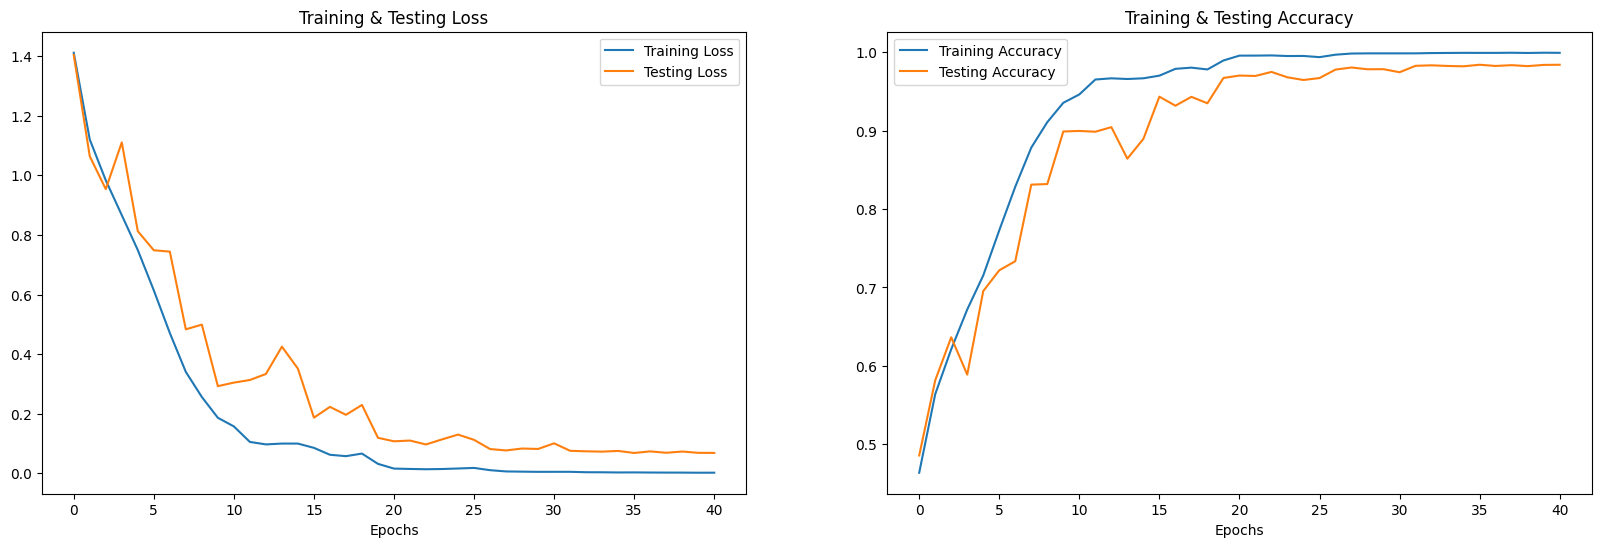

In [59]:
# Correct number of epochs based on the history
epochs = range(len(history.history['accuracy']))

# Plotting
fig, ax = plt.subplots(1, 2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20, 6)
ax[0].plot(epochs, train_loss, label='Training Loss')
ax[0].plot(epochs, test_loss, label='Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs, train_acc, label='Training Accuracy')
ax[1].plot(epochs, test_acc, label='Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")

plt.show()


In [36]:
# predicting on test data.
pred_test0 = model.predict(x_testcnn)
y_pred0 = encoder.inverse_transform(pred_test0)
y_test0 = encoder.inverse_transform(y_test)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred0.flatten()
df0['Actual Labels'] = y_test0.flatten()

df0.head(10)

304/304 [==============================] - 8s 25ms/step


,Predicted Labels,Actual Labels
0,happy,happy
1,happy,happy
2,fear,fear
3,fear,fear
4,angry,angry
5,disgust,disgust
6,neutral,neutral
7,neutral,neutral
8,neutral,neutral
9,sad,sad


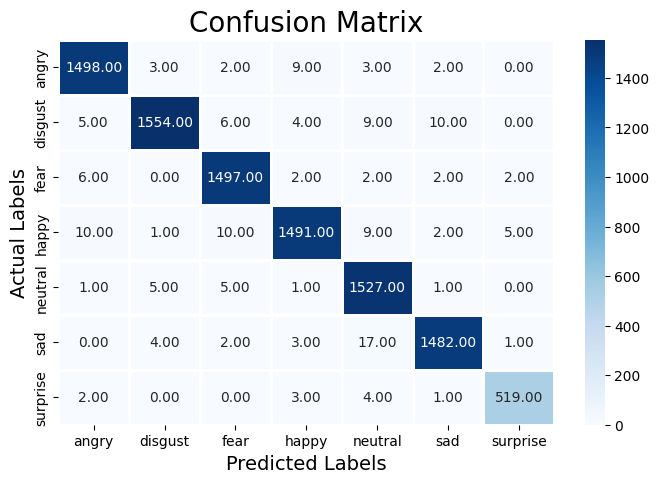

              precision    recall  f1-score   support

       angry       0.98      0.99      0.99      1517
     disgust       0.99      0.98      0.99      1588
        fear       0.98      0.99      0.99      1511
       happy       0.99      0.98      0.98      1528
     neutral       0.97      0.99      0.98      1540
         sad       0.99      0.98      0.99      1509
    surprise       0.98      0.98      0.98       529

    accuracy                           0.98      9722
   macro avg       0.98      0.98      0.98      9722
weighted avg       0.98      0.98      0.98      9722



In [37]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test0, y_pred0)
plt.figure(figsize = (8, 5))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test0, y_pred0))

# **Saving Best Model**

In [ ]:
# MLP for Pima Indians Dataset Serialize to JSON and HDF5
from tensorflow.keras.models import Sequential, model_from_json
model_json = model.to_json()
with open("CNN_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("CNN_model_weights.h5")
print("Saved model to disk") 

In [39]:
from tensorflow.keras.models import Sequential, model_from_json
json_file = open('CNN_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("best_model1_weights.h5")
print("Loaded model from disk")

Loaded model from disk


In [40]:
loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn,y_test)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

304/304 [==============================] - 8s 27ms/step - loss: 0.0685 - accuracy: 0.9842
accuracy: 98.42%


# **Saving and Loading our Standard Scaler and encoder**
* To save the StandardScaler object to use it later in a Flask API

In [41]:
import pickle

# Saving scaler
with open('scaler2.pickle', 'wb') as f:
    pickle.dump(scaler, f)

# Loading scaler
with open('scaler2.pickle', 'rb') as f:
    scaler2 = pickle.load(f)

# Saving encoder
with open('encoder2.pickle', 'wb') as f:
    pickle.dump(encoder, f)

# Loading encoder
with open('encoder2.pickle', 'rb') as f:
    encoder2 = pickle.load(f)

    
print("Done")    

Done


# **Test script**
* That can predict new record 

In [53]:
from tensorflow.keras.models import Sequential, model_from_json
json_file = open('CNN_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("best_model1_weights.h5")
print("Loaded model from disk")

Loaded model from disk


In [54]:
import pickle

with open('scaler2.pickle', 'rb') as f:
    scaler2 = pickle.load(f)

with open('encoder2.pickle', 'rb') as f:
    encoder2 = pickle.load(f)

    
print("Done")    

Done


In [55]:
def get_predict_feat(path):
    d, s_rate= librosa.load(path, duration=2.5, offset=0.6)
    res=extract_features(d)
    result=np.array(res)
    result=np.reshape(result,newshape=(1,2376))
    i_result = scaler2.transform(result)
    final_result=np.expand_dims(i_result, axis=2)
    
    return final_result

In [60]:
res = get_predict_feat("RAVDESS Emotional speech audio\Actor_01\\03-01-01-01-01-01-01.wav")
print(res.shape)

(1, 2376, 1)


In [61]:
emotions1={1:'Neutral', 2:'Calm', 3:'Happy', 4:'Sad', 5:'Angry', 6:'Fear', 7:'Disgust',8:'Surprise'}
def prediction(path1):
    res=get_predict_feat(path1)
    predictions=loaded_model.predict(res)
    y_pred = encoder2.inverse_transform(predictions)
    print(y_pred[0][0])    

In [62]:
prediction("RAVDESS Emotional speech audio\Actor_01\\03-01-01-01-01-02-01.wav")

1/1 [==============================] - 0s 35ms/step
neutral


In [63]:
prediction("RAVDESS Emotional speech audio\Actor_01\\03-01-01-01-01-02-01.wav")

1/1 [==============================] - 0s 39ms/step
neutral
